In [745]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import Random
from time import time
from inspyred import ec, benchmarks

In [746]:
class WorkoutRoutine(benchmarks.Benchmark):
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises):
        self.userLevel = userLevel.lower()
        self.time = time  # horas
        self.exercises = exercises  # diccionario {id: ejercicio}
        self.length = time * 6  # máx 6 ejercicios por hora
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        self.maximize = True
        self.bounder = ec.DiscreteBounder([1, 3005])

        self.difficulty_map = {
            "beginner": 0,
            "novice": 1,
            "intermediate": 2,
            "advanced": 3,
            "expert": 4,
            "master": 5
        }

        self.difficulty_minutes = {
            "beginner": 10,
            "novice": 12,
            "intermediate": 14,
            "advanced": 16,
            "expert": 18,
            "master": 20
        }

    def generator(self, random, args):
        candidate = [random.choice(range(3005)) for _ in range(self.length)]
        return candidate
    
    def evaluator(self, candidates, args):
        fitness = []
        for candidate in candidates:
            routine = self.get_exercises(candidate)
            n = len(routine)

            y_penalties = self.repetition_penalties(candidate)
            print(f"y_penalties: {y_penalties}")
            y_factor = sum(y_penalties) / n
            print(f"y_factor: {y_factor}")
            min_used = self.total_minutes(routine)
            min_total = self.time * 60
            min_factor = min(min_used / min_total, 1)
            print(f"min_factor: {min_factor}")
            muscles_factor = self.trained_muscles(routine) # porcentaje de músculos entrenados
            print(f"muscles_factor: {muscles_factor}")
            difficulty_factor = self.difficulty_score(routine)
            print(f"difficulty_factor: {difficulty_factor}")
            equipment_factor = self.used_equipment(routine)
            print(f"equipment_factor: {equipment_factor}")
            value = 100 * y_factor * min_factor * muscles_factor * difficulty_factor * equipment_factor
            print(f"value: {value}")
            # Bonus
            if value < 100:
                bonus = self.calculate_bonus(routine)
                value = min(value + bonus, 100)
            print(f"bonus: {bonus}")
            fitness.append(value)
        return fitness

    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]

    def total_minutes(self, routine):
        return sum(self.difficulty_minutes.get(ex['DifficultyLevel'].strip().lower(), 10) for ex in routine)

    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, eid in enumerate(candidate):
            for j in range(i):
                if candidate[j] == eid:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.95
                    elif dist <= 8:
                        penalties[i] = 0.99
                    else:
                        penalties[i] = 1
                    break
        return penalties

    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.05 * diff)
            else:
                score = max(0, 1 - 0.03 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)

    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])
        if not self.equipment:
            return 1
        return min(0.1 * (len(used) / len(self.equipment)) + 0.9, 1)

    def trained_muscles(self, routine):
        trained = set(ex['TargetMuscleGroup'] for ex in routine if ex['TargetMuscleGroup'])
        if not self.requestMuscles:
            return 1
        # Filtrar solo los músculos solicitados que realmente han sido entrenados
        matched = [muscle for muscle in self.requestMuscles if muscle in trained]
        porcentaje_entrenados = len(matched) / self.length

        return min(1-porcentaje_entrenados, 1)


    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()
        for ex in routine:
            muscle = ex['TargetMuscleGroup']
            region = ex['BodyRegion']
            if muscle not in self.requestMuscles:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)
        return extra_bonus


In [747]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

In [748]:
test = [1776,2258,367,1255,2362]


# Define the problem

In [ ]:
userLevel = "beginner"
equipment = []
requestMuscles = ["Quadriceps"]
duration = 1
userID = 12345
exercises = df.to_dict(orient='records')
problem = WorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises)
problem.evaluator([test], None)

y_penalties: [1, 1, 1, 1, 1]
y_factor: 1.0
min_factor: 0.3111111111111111
muscles_factor: 0.9444444444444444
difficulty_factor: 0.97
equipment_factor: 1
value: 28.501234567901232
bonus: 0.2


[28.70123456790123]

# Executing the GA

In [750]:
# Initializing the observer
def diversity(population):
    return np.array([i.candidate for i in population]).std(axis=0).mean()

def fitness_diversity_observer(population, num_generations, num_evaluations, args):
    """Observer to track best fitness and diversity."""
    best = max(population).fitness
    div = diversity(population)

    args['best_fitness_historic'].append(best)
    args['diversity_historic'].append(div)

In [ ]:
seed = time() # the current timestamp
prng = Random()
prng.seed(seed)

ga = ec.GA(prng)
ga.selector = ec.selectors.fitness_proportionate_selection
ga.variator = [ec.variators.n_point_crossover,
               ec.variators.bit_flip_mutation]
ga.replacer = ec.replacers.generational_replacement
ga.terminator = ec.terminators.generation_termination

best_fitness_historic = []
diversity_historic = []
ga.observer = [fitness_diversity_observer, ec.observers.stats_observer]

final_pop = ga.evolve(generator=problem.generator,
                      evaluator=problem.evaluator,
                      bounder=problem.bounder,
                      maximize=problem.maximize,
                      pop_size=100,
                      max_generations=100,
                      num_elites=4,
                      num_selected=100,
                      crossover_rate=1,
                      num_crossover_points=1,
                      mutation_rate=0.05,
                      best_fitness_historic=best_fitness_historic,
                      diversity_historic=diversity_historic)

best = max(ga.population)
print('Best Solution: {0}: {1}'.format(str(best.candidate), best.fitness))


y_penalties: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_factor: 1.0
min_factor: 1
muscles_factor: 0.9444444444444444
difficulty_factor: 0.9027777777777778
equipment_factor: 1
value: 85.26234567901234
bonus: 0.8999999999999999
y_penalties: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_factor: 1.0
min_factor: 1
muscles_factor: 0.9444444444444444
difficulty_factor: 0.9027777777777778
equipment_factor: 1
value: 85.26234567901234
bonus: 0.9999999999999999
y_penalties: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_factor: 1.0
min_factor: 1
muscles_factor: 0.9444444444444444
difficulty_factor: 0.9083333333333334
equipment_factor: 1
value: 85.78703703703705
bonus: 1.05
y_penalties: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_factor: 1.0
min_factor: 1
muscles_factor: 0.9444444444444444
difficulty_factor: 0.9277777777777777
equipment_factor: 1
value: 87.62345679012344
bonus: 0.8
y_penalties: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y

In [ ]:
# Print the routine according to the best solution
for i in best.candidate:
    print(exercises[i]['TargetMuscleGroup'] + " - " + exercises[i]['DifficultyLevel'] + " - " + exercises[i]['BodyRegion'])

Shoulders - Intermediate - Full Body
Back - Beginner - Upper Body
Triceps - Novice - Upper Body
Back - Beginner - Upper Body
Biceps - Novice - Upper Body
Back - Beginner - Upper Body
Biceps - Beginner - Upper Body
Back - Novice - Upper Body
Shoulders - Beginner - Upper Body
Back - Beginner - Upper Body
Chest - Beginner - Upper Body
Quadriceps - Beginner - Lower Body
Abdominals - Beginner - Midsection
Biceps - Beginner - Upper Body
Chest - Beginner - Upper Body
Biceps - Beginner - Upper Body
Chest - Beginner - Upper Body
Trapezius - Beginner - Upper Body


C:\Users\pablo\AppData\Local\Temp\ipykernel_11176\1678658813.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Diversity')

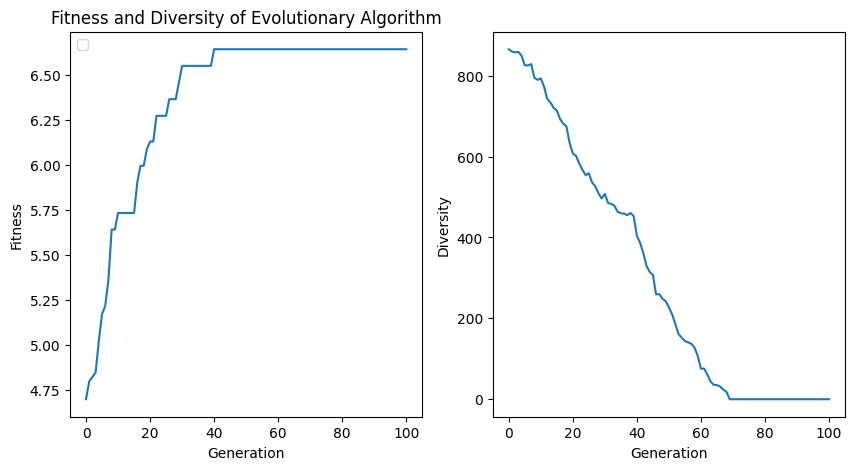

In [ ]:
# plot the fitness and diversity in two separate subplots
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(best_fitness_historic)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness and Diversity of Evolutionary Algorithm')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diversity_historic)
plt.xlabel('Generation')
plt.ylabel('Diversity')